In [1]:
%matplotlib inline

import PIL
import numpy as np
import pandas as pd
import torch
from easyimages import EasyImageList
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, log_loss

from skorch.utils import *
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms


/home/i008/anaconda3/envs/dl/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# %env CUDA_VISIBLE_DEVICES=None

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Define the new dataset

Keep in mind we are inheriting the Dataset base-class. And we have to override 2 methods:
 - \____len____
 - \____getitem____

1. load_image_and_target reads the data from the csv file and converts the image array into a PIL object - this is not mandatory but useful, as many handy functions like transform, operate on PIL.Images
2. getitem, takes a index and it should properly return for every number between (0, and len)
3. len should return the number of samples (images) in your dataset

In [4]:
label_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


class FashionMnist(Dataset):

    def __len__(self):
        return len(self.metadata_df)

    def __init__(self, metadata_df,
                 transform=None):

        self.metadata_df = metadata_df.copy()
        self.transform = transform

    def __getitem__(self, index):
        X, y = self.load_image_and_target(index)
        # We can transform the output images here, cast to torch data-format and/or do augmentations
        X = self.transform(X)

        return X, y

    def load_image_and_target(self, index):
        # .iloc is short for integer loc it returns a row of data based on its ored not index-value(if not the same)
        oneimage = self.metadata_df.iloc[index]
        image, y = PIL.Image.fromarray(
            np.array(oneimage[1:]).reshape(28, 28).astype('uint8'), 'L'), oneimage[0]

        return image, y

    def _load_image_metadata(self, index):

        image_path = df.iloc[index]

        image = PIL.Image.open(image_path)
        image.meta_data

        image, metada

    def collate_func(self, batch):
        pass


PATH_TO_FMNIST_TRAIN = './data/fashion-mnist_train.csv'
PATH_TO_FMNIST_TEST = './data/fashion-mnist_test.csv'


dftrain = pd.read_csv(PATH_TO_FMNIST_TRAIN).sample(frac=1)
dftest = pd.read_csv(PATH_TO_FMNIST_TEST).sample(frac=1)

transform_train = transforms.Compose([transforms.ToTensor()])
fmnist_train = FashionMnist(dftrain, transform=transform_train)

transform_test = transforms.Compose([transforms.ToTensor()])
fmnist_test = FashionMnist(dftest, transform=transform_test)

In [5]:
X, y = fmnist_test[0]
X.shape

torch.Size([1, 28, 28])

In [6]:
one_sample_image = dftrain.iloc[30].tolist()
label, image = one_sample_image[0], one_sample_image[1:]
label
im = np.array(image).reshape((28, 28))
plt.imshow(im, cmap='gray')

### our datasets supports getitem wich means we can do:

In [7]:
image, label = fmnist_train[0]
print(type(image))
print(type(label), label)

image, label = fmnist_train.load_image_and_target(0)
print(type(image), image)

<class 'torch.Tensor'>
<class 'numpy.int64'> 7
<class 'PIL.Image.Image'> <PIL.Image.Image image mode=L size=28x28 at 0x7F68D9592390>


In [8]:
fmnist_dl = DataLoader(fmnist_train, batch_size=32, num_workers=2)
batch_iterator = iter(fmnist_dl)
X, y = next(batch_iterator)

for batch in fmnist_dl:
    break
for batch in fmnist_dl:
    break

print("y:", batch[1].shape)
print("X: ", batch[0].shape)

y: torch.Size([32])
X:  torch.Size([32, 1, 28, 28])


In [9]:
batch[0].shape

torch.Size([32, 1, 28, 28])

### Explore your dataset
Its always good to start with getting some inside about your dataset. Thats usuall much easier and less important in image datasets - but it does not mean you should not do it.

Things you should always think about working with an image dataset are:
- Check target distribiution (counts) do you see a strong imbalance?
- Check sizes of images, if not all images are of the same size you might destroy your data with wrong transformations


In [10]:
dftrain.label.value_counts().plot(kind='bar')

### visualize a batch
Its always a good idea to sanity check the output of our loaders

In [11]:
im = EasyImageList.from_torch_batch(X.repeat(1, 3, 1, 1),  # we need to add 3 channels to the images
                                    mean=None,
                                    std=None)
im.numpy_grid()

### Define your model architecture
As a baseline model dont  overcomplicate, either use some very simple architecture or go with something well established like resnet. There will be time to go more fancy

Here we define a model with two CONV blocks comprising of a typical:
*Conv>BN>RELU>POOL* setting

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self, num_of_class):
        super(SimpleCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # we reduce the volume shape 1 times (1 Pooling Operations)
        self.fc = nn.Linear(int(28/2) * int(28/2) * 16, 100)
        self.fc2 = nn.Linear(100,10)
        

    def forward(self, x):
        out = self.layer1(x)

        out = out.reshape(out.size(0), -1)
        

        out = self.fc(out)
        out = self.fc2(out)
        return out

In [13]:
# Always check your model are you atleasy able to make a forward pass and shapes match your expectations?
image = torch.randn(32, 1, 28, 28)
cnn = SimpleCNN(10)
# out_layer2 = cnn.layer2(cnn.layer1(image))
# out_layer2.reshape(out_layer2.size(0), -1).shape
# output = cnn(image)
print("input shape:")
print(image.shape)
print("output shape:")

input shape:
torch.Size([32, 1, 28, 28])
output shape:


### Define your loss function / crieterion and optimizer
Its a good idea to create some dummy data and pass it trough the cost function to make sure you uderstand what the shapes shoudl be

In case of CrossEntropyLosss We want our predictions to be of shape (BATCH_SIZE, N_CLASSES) and y_true of shape (BS)
(Basically a vector of number that corespond to the class)


In [14]:
LR = 0.001
BATCH_SIZE = 256
DATASET_USAGE_SIZE = 0.05

# MEAN = [0.485, 0.456, 0.406]
# STD = [0.229, 0.224, 0.225]
RESIZE = 28

cnn = SimpleCNN(10)

# one of ['ASGD','Adadelta', 'Adagrad','Adam', 'Adamax','LBFGS', 'RMSprop','Rprop','SGD',SparseAdam']
OPTIMIZER = 'Adam'
optimizer = getattr(torch.optim, OPTIMIZER)(cnn.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

cnn.to(DEVICE)

# Create dataset loaders

dftrain = pd.read_csv(PATH_TO_FMNIST_TRAIN).sample(frac=DATASET_USAGE_SIZE)
dftest = pd.read_csv(PATH_TO_FMNIST_TEST).sample(frac=0.1)

transform_train = transforms.Compose(
    [transforms.Resize(RESIZE), transforms.ToTensor()])
fmnist_train = FashionMnist(dftrain, transform=transform_train)

transform_test = transforms.Compose(
    [transforms.Resize(RESIZE), transforms.ToTensor()])
fmnist_test = FashionMnist(dftest, transform=transform_test)

fmnist_train_dl = DataLoader(fmnist_train, batch_size=BATCH_SIZE)
fmnist_test_dl = DataLoader(fmnist_test, batch_size=BATCH_SIZE)



tensor(2.7693)

In [15]:
# def process_train_batch(batch):
#     X, y = batch
#     return X.to(DEVICE), y.to(DEVICE)


# def process_eval_batch(batch):
#     X, y = batch
#     X = X.to(DEVICE)
#     y = y.to(DEVICE).detach().cpu().numpy()
#     return X, y


# def evaluate_model(model, test_loader, print_info=False):
#     with torch.no_grad():
#         model.eval()
#         collect_results = []
#         collect_target = []
#         for batch in test_loader:
#             X, y = process_eval_batch(batch)
#             pred = model(X)
#             collect_results.append(
#                 F.softmax(pred, dim=1).detach().cpu().numpy())
#             collect_target.append(y)

#         preds_proba = np.concatenate(collect_results)
#         preds = preds_proba.argmax(axis=1)

#         targets = np.concatenate(collect_target)

#         ll = log_loss(targets, preds_proba)
#         acc = accuracy_score(targets, preds)
#         if print_info:
#             print("test log-loss: {}".format(ll))
#             print("overall accuracy:  {}".format(ac))
#             #print(classification_report(targets, preds))
#         model.train()
#         return ll, acc


# collect_metrics = []
# collect_loss = []
# for epoch in range(25):
#     lossacc = 0
#     for i, batch in enumerate(fmnist_train_dl):
#         optimizer.zero_grad()
#         X, y = process_train_batch(batch)
#         y_pred = cnn(X)
#         loss = criterion(y_pred, y)
#         loss.backward()
#         optimizer.step()
#         collect_loss.append(float(loss.detach().cpu().numpy()))

#     lltest, acctest = evaluate_model(cnn, fmnist_test_dl)
#     lltrain, acctrain = evaluate_model(cnn, fmnist_train_dl)
#     collect_metrics.append([lltest, lltrain, acctest, acctrain])
#     print("test: loss: {}  acc: {}".format(lltest, acctest))
#     print("train: loss: {}  acc: {}".format(lltrain, acctrain))

# LR-finder implementation
![alt text](static/learing_rate_finder_lr_plot.png "Title")


In [16]:
import math
def find_lr(model, loss_fn, optimizer, data_loader, init_value=1e-8, final_value=10.0):
    model = model.to(DEVICE)
    number_in_epoch = len(data_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in data_loader:
        batch_num += 1
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 20 * best_loss:
            return log_lrs[10:-5], losses[10:-5]

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values

        losses.append(loss)
        log_lrs.append(lr)

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    return log_lrs[10:-5], losses[10:-5]

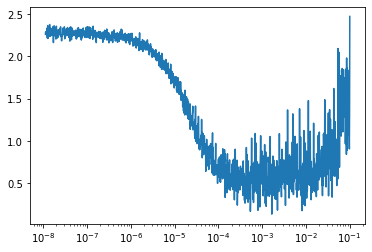

In [18]:
dftrain = pd.read_csv(PATH_TO_FMNIST_TRAIN).sample(frac=1)
fmnist_train = FashionMnist(dftrain, transform=transform_train)
data_loader = DataLoader(fmnist_train, batch_size=32)
cnn = SimpleCNN(10).to(DEVICE)
optimizer = getattr(torch.optim, OPTIMIZER)(cnn.parameters(), lr=0.001)


In [ ]:
%matplotlib inline 
x, y = find_lr(cnn, criterion, optimizer, data_loader)
plt.plot(x, y)
plt.xscale('log')